# Autoencoders in fastai

This is the corresponding notebook for my blog post on creating autoencoders in fastai.

## Import Required Libraries

In [ ]:
#from fastai import *
#from fastai.vision import *

from fastbook import *
from fastai.vision.all import *
# import torchvision

#config = Config()
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F



## Import Data

In [ ]:
from fastai.vision.all import *
from fastai.data import *

In [ ]:
# load our core data
filename = "zappos-50k-simplified_sort" # no features

filename = "full_db" # no features

df = pd.read_pickle(f"data/{filename}.pkl")



#DATA_path = Path.home()/'Projects/DATABASE'
#path_images = Path(config.d['data_path']+'/ut-zap50k-images')


# Lets test a few different sizes

IMG_SIZE_LG = 224
IMG_SIZE_MD = 160
IMG_SIZE_SM = 128
IMG_SIZE = IMG_SIZE_MD

IMG_SIZES = {"small":  IMG_SIZE_SM,
             "medium": IMG_SIZE_MD,
             "large":  IMG_SIZE_LG}


In [ ]:
# some helper functions.
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
def splitter(df):
    train = df.index[df['train']].tolist()
    valid = df.index[df['validate']].tolist()
    return train,valid


batch_tfms = Normalize.from_stats(*imagenet_stats)
rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

In [ ]:
doc(ImageBlock)


In [ ]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = Path(/home/ergonyc/Projects/Project2.0/snkr-finder/data/scraped)

batchsize = 32
tfms = get_transforms(do_flip = True)

src = (ImageImageList.from_folder(image_path).use_partial_data(0.1).split_by_rand_pct
       .split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False) )

SyntaxError: invalid syntax (<ipython-input-5-02f113b9e1ba>, line 4)

In [ ]:
data

NameError: name 'data' is not defined

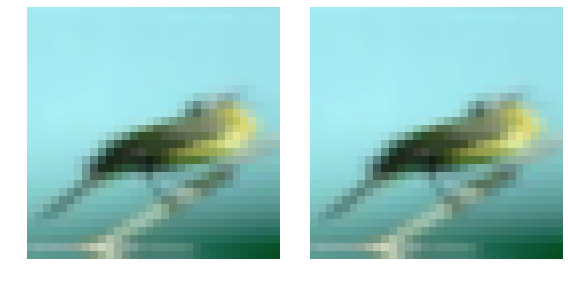

In [ ]:
data.show_batch(rows = 1)

### Array Data
If using an array dataset you can use the below code:

In [ ]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [ ]:
train_data = np.random.rand(50,5)
valid_data = np.random.rand(5, 5)
train_ds = ArrayDataset(train_data, train_data)
valid_ds = ArrayDataset(valid_data, valid_data)

In [ ]:
array_data = DataBunch.create(train_ds, valid_ds, bs=32)
array_data

DataBunch;

Train: <__main__.ArrayDataset object at 0x12d8c1f98>;

Valid: <__main__.ArrayDataset object at 0x12c935630>;

Test: None

## Model
Here I have included the model I used for the image dataset, however you can create your own custom model. If you are using an array dataset you will need to.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Learner

In [ ]:
autoencoder = Autoencoder()

In [ ]:
learn = Learner(data, autoencoder, loss_func = F.mse_loss)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.45E-02


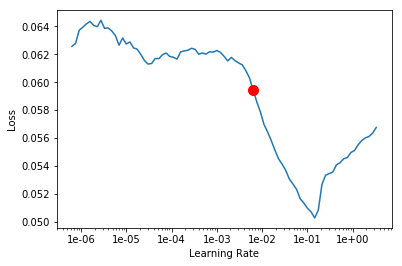

In [ ]:
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(10, max_lr = 1e-02)

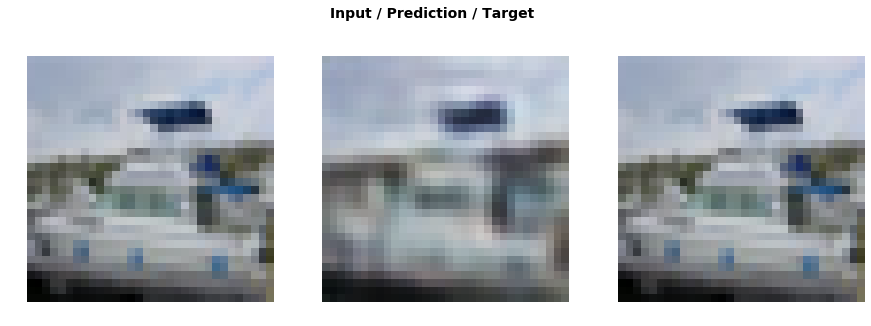

In [ ]:
learn.show_results(rows=1, imgsize=5)

## Using the Encoder

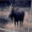

In [ ]:
example = data.one_batch()[0]
Image(example[0])

In [ ]:
example = data.one_batch(denorm = False)
inputs = example[0]

In [ ]:
inputs.shape

torch.Size([32, 3, 32, 32])

In [ ]:
encoded = autoencoder.encode(inputs)

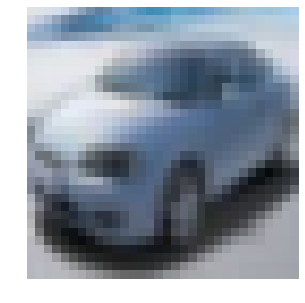

In [ ]:
Image(example[1][0]).show(figsize = (5,5))

In [ ]:
decoded = autoencoder.decoder(encoded)

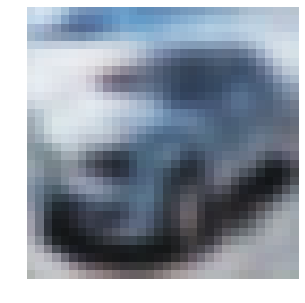

In [ ]:
Image(decoded[0].detach()).show(figsize = (5,5))